# Baustellenlärm

Vis-à-vis befindet sich eine Baustelle. Wann gehts dort besonders laut zu und her? Das soll eine einfache Schallpegelaufzeichnung zeigen. Zum Einsatz kommt ein mit einem Mikrofon bestückter Arduino. Alle 15 Sekunden wacht die Platine auf, analysiert für einige Sekunden den Schallpegel, übermittelt die Daten und schläft wieder ein. Die dabei entstandenen Daten werden nachfolgend ausgewertet. 

### Datenaufbereitung

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [122]:
# Die Daten werden importiert. 
#df = pd.read_csv('/home/this/Downloads/noiselog.csv', delimiter=';', header=None)
df = pd.read_csv('http://borniert.com/noiselog/noiselog.csv', delimiter=';', header=None)
df.columns = ['datetime', 'sensor', 'value']
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')
df['sensor'] = df['sensor'].str.strip()

In [123]:
# Wie viele Einträge enthält der Datensatz? 
len(df)

189017

In [124]:
# Der Testbetrieb wird ausgefiltert. 
df = df.loc['2019-08-12':]

In [125]:
# Analysiert werden lediglich die Daten des einen der beiden Sensoren.
df = df[df['sensor'] == 'hallerstrasse_2']

In [126]:
# Wie viele Einträge enthält der Datensatz? 
len(df)

120475

In [127]:
# Die Ausreisser werden gefiltert. Sie könnten bei Manipulationen an der Store oder am Gerät entstanden sein. 
df = df[df['value'] < df['value'].quantile(.95)]

In [128]:
# Wie viele Einträge enthält der Datensatz? 
len(df)

114425

In [129]:
# Ein Blick auf die ersten paar Zeilen des Datensatzes.
df.head()

,sensor,value
datetime,,
2019-08-19 09:06:53,hallerstrasse_2,0.64
2019-08-19 09:07:14,hallerstrasse_2,0.64
2019-08-19 09:07:35,hallerstrasse_2,0.32
2019-08-19 09:07:56,hallerstrasse_2,3.22
2019-08-19 09:32:19,hallerstrasse_2,1.61


### Auswertungen

In [130]:
# Wie viele Messwerte sind verfügbar? 
len(df)

114425

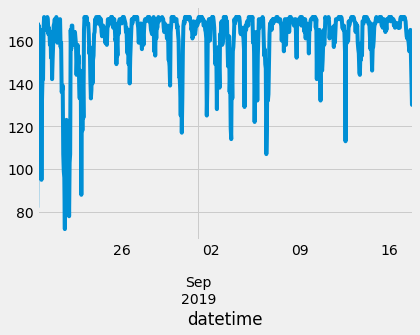

In [131]:
# Wie viele Messwerte pro Stunde sind verfügbar? 
df.resample('60min').count()['value'].plot()

In [132]:
# Welches ist der erste Messwert? 
df.index.min()

Timestamp('2019-08-19 09:06:53')

In [133]:
# Welches ist der letzte Messwert? 
df.index.max()

Timestamp('2019-09-17 20:51:49')

In [134]:
# Wie lange dauert die Messperiode?
df.index.max() - df.index.min()

Timedelta('29 days 11:44:56')

In [135]:
# An welchen Tagen wars am lautesten? 
df.resample('D').mean().sort_values(by='value', ascending=False).head(10)

,value
datetime,
2019-08-21,3.222952
2019-08-22,2.721332
2019-08-19,2.617590
2019-08-30,2.574509
2019-09-17,2.522895
2019-08-23,2.435622
2019-09-06,2.371881
2019-09-03,2.345772
2019-09-02,2.325614


In [136]:
# Wie hoch ist der Schallpegel im Durchschnitt in der Nacht?
nacht = range(0,5)
df[df.index.hour.isin(nacht)]['value'].mean()

0.8575018338902928

In [137]:
# Wie hoch ist der Schallpegel im Durchschnitt während des Vormittags?
vormittag = range(7,12)
df[df.index.hour.isin(vormittag)]['value'].mean()

2.672560903650004

In [138]:
# Wie hoch ist der Schallpegel im Durchschnitt während des Nachmittags?
nachmittag = range(13,19)
df[df.index.hour.isin(nachmittag)]['value'].mean()

2.9443284499909566

In [139]:
# Wie hoch ist der Schallpegel im Durchschnitt unter der Woche?
df[df.index.dayofweek < 5]['value'].mean()

2.1996848864450183

In [140]:
# Wie hoch ist der Schallpegel im Durchschnitt am Wochenende?
df[df.index.dayofweek >= 5]['value'].mean()

1.478933275076462

In [141]:
# Wie hoch ist der Schallpegel im Durchschnitt während der Arbeitszeiten?
df_temp = df[df.index.dayofweek < 5]
df_temp[(df_temp.index.hour.isin(vormittag)) | (df_temp.index.hour.isin(nachmittag))]['value'].mean()

3.2401981835434457

In [142]:
# Wie hoch ist der Schallpegel im Durchschnitt während der Sperrzeiten?
df_temp = df[~((df.index.hour.isin(vormittag)) | (df.index.hour.isin(nachmittag)))]
df_temp = df_temp.append(df[df.index.dayofweek >= 5])
df_temp['value'].mean()

1.3795265836628248

In [143]:
# Wie sieht der durchschnittliche Tag aus? 
df_temp = df#.resample('30min').mean()
df_temp.groupby(df_temp.index.hour).mean()#.plot(figsize=[12,4])

,value
datetime,
0,1.058367
1,0.924063
2,0.813287
3,0.742897
4,0.750728
5,0.921443
6,1.309321
7,2.245008
8,2.770100


In [152]:
# Wie hoch ist der Schallpegel an Arbeitstagen im Durchschnitt pro Stunde?
df_temp = df[df.index.dayofweek < 5]
df_temp['value'].groupby(df_temp.index.hour).mean().to_csv('output/einnormalerarbeitstag.csv')

/home/this/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [145]:
# Die Daten werden für den Datawrapper exportiert. 
df_temp = df[['value']].resample('30min').mean()
df_temp[df_temp['value'] < 5]
df_temp.to_csv('output/alle_datawrapper.csv')

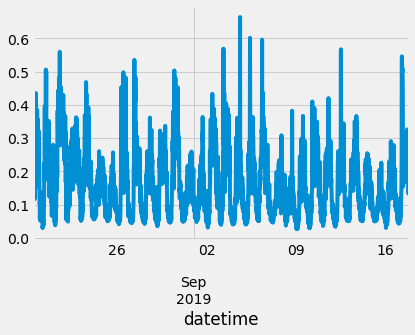

In [146]:
# Relative Werte werden berechnet. 
df['value_rel'] = df['value'] / df['value'].max()
df[['sensor', 'value_rel']].resample('15min')['value_rel'].mean().plot()

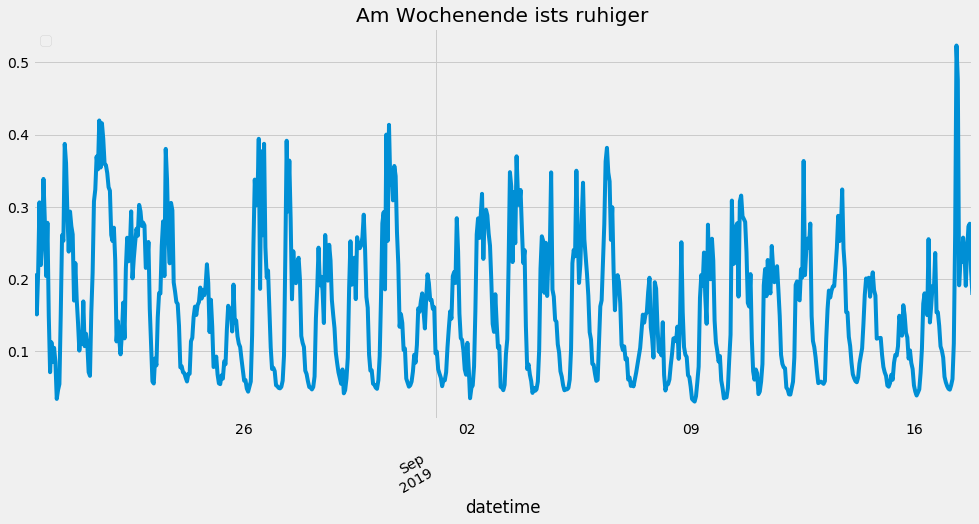

In [147]:
# Eine Grafik zeichnen. 
import matplotlib
fig, ax = plt.subplots(figsize=[15,8])
df[['sensor', 'value_rel']].resample('60min')['value_rel'].mean().plot()

#ax.xaxis.set_minor_formatter(matplotlib.dates.DateFormatter('%H'))
#plt.xticks([x for x in xticks])
#ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d. %b'))
fig.autofmt_xdate()
plt.legend('')
plt.title('Am Wochenende ists ruhiger')
plt.show()

In [156]:
# Wie oft wird der auf die Minute gemittelte Grundlärmpegel pro Tag ums Vierfache überschritten?
df_temp = df[['value']].resample('1min').mean()
grundlärm = df_temp['value'].quantile(.25)
df_temp[df_temp['value'] > (4 * grundlärm)].resample('D').count().to_csv('output/vierfachergrundlärm.csv')